# 🎯PRACTICAL 2 - Insertion Sort Real World Application



Dataset Used - Video Games Sales Data (2016) <br><br>

URL - https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings

<br>

<p>The analysis in this notebook is based on the VideoGameSales2016.csv dataset, which is subset of original dataset with its two attributes and includes commercial performance data for a large collection of video game titles.
It provides:
</p>
1. Game Name <br>
2. Global Sales (in millions)

This dataset is used to:
Generate random sample files for different input sizes.
Apply insertion sort on each sample and sort the data on the basis of highest selling titles.

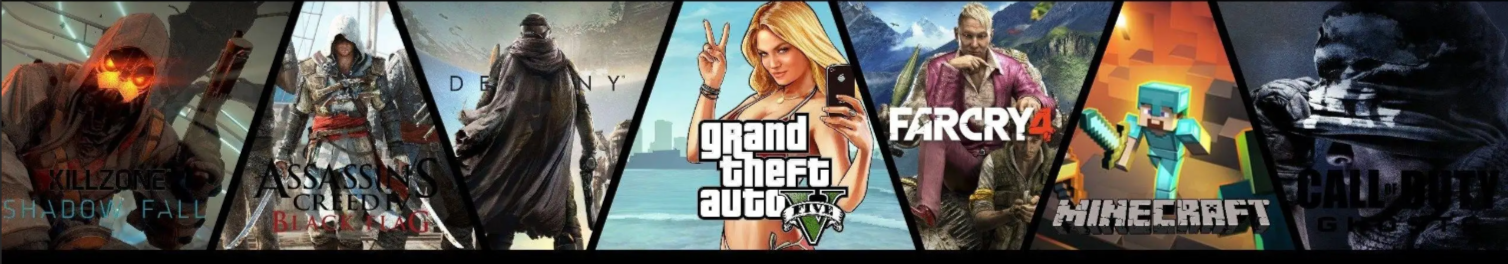

In [23]:
# fetching preprocessed subset of dataset
!wget https://raw.githubusercontent.com/HemantkMCA25/DAA_Practical/refs/heads/main/VideoGameSales2016.csv

--2026-01-28 09:17:13--  https://raw.githubusercontent.com/HemantkMCA25/DAA_Practical/refs/heads/main/VideoGameSales2016.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 516691 (505K) [text/plain]
Saving to: ‘VideoGameSales2016.csv.3’

VideoGameSales2016. 100%[===================>] 504.58K  --.-KB/s    in 0.04s   

2026-01-28 09:17:14 (12.1 MB/s) - ‘VideoGameSales2016.csv.3’ saved [516691/516691]



In [24]:
# importing required libraries for file & folder management and creation
import os
import pandas as pd
import numpy as np

In [25]:
## Sample Generation Code from dataset

# ---- Configuring path ----
SOURCE_CSV = 'VideoGameSales2016.csv'   # filename
INPUT_DIR = 'input'
SIZES = list(range(10, 101, 10))
N_PER_SIZE = 10                         # 10 random files per size
SEED = 19                               # for reproducibility

# ---- Read source ----
df = pd.read_csv(SOURCE_CSV) # read the csv

# Create input directory
os.makedirs(INPUT_DIR, exist_ok=True) # create folder 'input' for input files

# Generate 10 random files for each size
rng = np.random.default_rng(SEED)
for size in SIZES:
    for k in range(1, N_PER_SIZE + 1):
        idx = rng.choice(len(df), size=size, replace=False)
        sample = df.iloc[idx].copy()
        out_name = f'size{size:03d}_sample{k:02d}.csv'
        sample.to_csv(os.path.join(INPUT_DIR, out_name), index=False)

print(f"Created {len(SIZES)*N_PER_SIZE} CSVs in '{INPUT_DIR}/'")

Created 100 CSVs in 'input/'


mkdir command used to create directory 'sorted' to store output files

In [26]:
mkdir -p sorted

In [27]:
%%writefile R_No_19_HemantKumar_main.cpp

// importing required packages

#include <fstream>
#include <string>
#include <vector>
#include <map>
#include <cstdlib>
#include <cerrno>

// ------------------ Row Record Structure ------------------
struct Row {
    std::string name;
    double sales;
};

// ------------------ CSV Parser ------------------

static bool parse_csv_line(const std::string& line, std::string& name, double& sales) {
    std::size_t comma = line.find(',');
    if (comma == std::string::npos) return false;

    name = line.substr(0, comma);
    std::string rhs = line.substr(comma + 1);

    errno = 0;
    const char* s = rhs.c_str();
    char* end = nullptr;
    double val = std::strtod(s, &end);

    if (s == end || errno == ERANGE) return false; // not a number or overflow
    sales = val;
    return true;
}

// file reader
void readCsvFile(const std::string& path, std::vector<Row>& v) {
    std::ifstream in(path);
    std::string line;

    // skip header
    std::getline(in, line);

    while (std::getline(in, line)) {
        if (line.empty()) continue;
        std::string name;
        double sales;
        if (parse_csv_line(line, name, sales)) {
            v.push_back({name, sales});
        }
    }
}

// writes a file
void writeCsvFile(const std::string& path, const std::vector<Row>& v) {
    std::ofstream out(path);
    out << "Name,Global_Sales\n";
    for (const auto& r : v) {
        out << r.name << "," << r.sales << "\n";
    }
}

// ------------------ Insertion Sort (DESCENDING) ------------------
unsigned long long insertionSortBySalesDescCount(std::vector<Row>& a) {
    unsigned long long comparisons = 0;
    for (int i = 1; i < (int)a.size(); i++) {
        Row key = a[i];
        int j = i - 1;
        while (j >= 0) {
            ++comparisons; // comparisons are made here
            if (a[j].sales < key.sales) {
                a[j + 1] = a[j];
                --j;
            } else {
                break;
            }
        }
        a[j + 1] = key;
    }
    return comparisons;
}

// ------------------ Small helpers to zero-pad filenames ------------------
static std::string pad2(int x) {
    std::string s = std::to_string(x);
    if (x < 10) return "0" + s;
    return s;
}
static std::string pad3(int x) {
    if (x < 10)  return "00" + std::to_string(x);
    if (x < 100) return "0"  + std::to_string(x);
    return std::to_string(x);
}

// ------------------ Main: -> read -> sort -> write -> metrics ------------------
int main() {
    // Aggregate comparisons per n to compute averages later
    std::map<int, unsigned long long> totalComparisons;
    std::map<int, int> fileCount;

    // Generate filenames and process
    for (int n = 10; n <= 100; n += 10) {
        for (int d = 1; d <= 10; ++d) {
            std::string fname = "size" + pad3(n) + "_sample" + pad2(d) + ".csv";
            std::string inPath  = "input/"  + fname;
            std::string outPath = "sorted/" + fname;

            // read
            std::vector<Row> rows;
            readCsvFile(inPath, rows);

            // sort (descending) + count comparisons
            unsigned long long comps = insertionSortBySalesDescCount(rows);

            // write
            writeCsvFile(outPath, rows);

            // metrics processing
            totalComparisons[n] += comps;
            fileCount[n] += 1;
        }
    }

    // Write average comparisons per n
    std::ofstream m("metrics.csv");
    m << "n,files,avg_comparisons\n";
    for (int n = 10; n <= 100; n += 10) {
        double avg = fileCount[n] ? (double)totalComparisons[n] / (double)fileCount[n] : 0.0;
        m << n << "," << fileCount[n] << "," << avg << "\n";
    }
    m.close();

    return 0;
}

Overwriting R_No_19_HemantKumar_main.cpp


Code compilation and execution

In [28]:
!g++ R_No_19_HemantKumar_main.cpp -o R_No_19_HemantKumar_main
!./R_No_19_HemantKumar_main

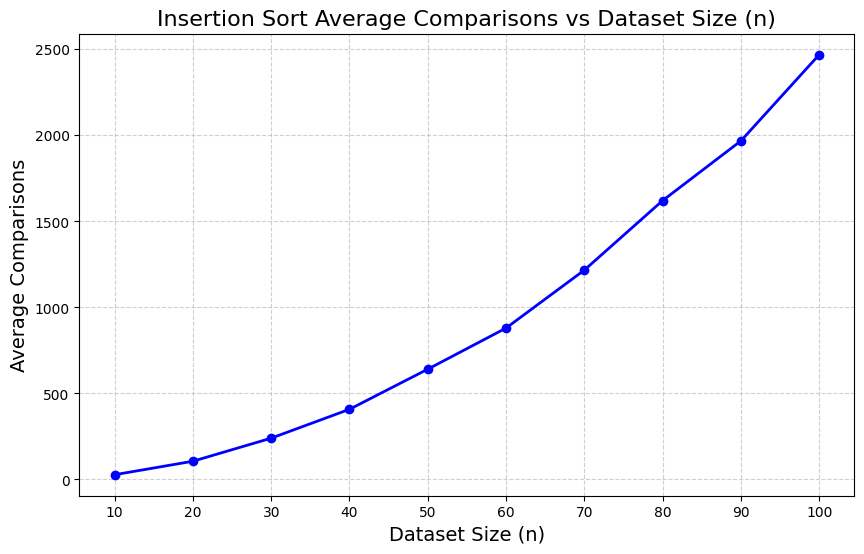

In [29]:
## plotting the graph for comparisons done while sorting
import matplotlib.pyplot as plt

# Load your metrics.csv
df = pd.read_csv("metrics.csv")

# Extract values
n_values = df['n']
avg_comp = df['avg_comparisons']

# Plot
plt.figure(figsize=(10,6))
plt.plot(n_values, avg_comp, marker='o', linewidth=2, color='blue')

plt.title("Insertion Sort Average Comparisons vs Dataset Size (n)", fontsize=16)
plt.xticks(range(10, 101, 10))
plt.xlabel("Dataset Size (n)", fontsize=14)
plt.ylabel("Average Comparisons", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("Comparisons")
plt.show()